In [11]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import astropy.stats as st


In [32]:
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod

In [22]:
B_North   = np.genfromtxt('EDD_Bren_2MRS_North.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
B_South   = np.genfromtxt('EDD_Bren_2MRS_South.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
KT_All    = np.genfromtxt('EDD_KT_All.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)


In [166]:
########################################################
def genZP(table, reject=[], weird=[], clusterName='', 
               nest=''):
    
    ctl   = np.genfromtxt('zp_photom_reduced.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
    PGC  = ctl['PGC']
    dist = ctl['d']
    ID   = ctl['Name']
    
    pgc  = table['pgc']
    Vhel = table['Vhel']
    Vls  = table['Vls']
    
   
    pgc_  = []
    Vhel_ = []
    Vls_  = []
    dist_ = []
    ID_   = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject:
            
            indx, = np.where(PGC==idd)
            pgc_.append(pgc[i])
            Vhel_.append(Vhel[i])
            Vls_.append(Vls[i])
            dist_.append(dist[indx][0])
            ID_.append(ID[indx][0])
    
    dist_=np.asarray(dist_)
    ID_=np.asarray(ID_)    
    Vhel_ = np.asarray(Vhel_)
    Vls_ = np.asarray(Vls_)
    
            

    outDict = {'pgc':pgc_, 'name': clusterName, 'Vhel': Vhel_, 'Vls': Vls_, 'dist':dist_, 'ID':ID_}
    
    return outDict

def ZP4Vmod(table):
    reject = []
    weird = []
    return genZP(table, reject=reject, weird=weird)
    
########################################################
def genCluster(table, reject=[], weird=[], clusterName='', 
               nest='NEST_100001'):
    
    ctl   = np.genfromtxt(nest+'.csv' , delimiter='|', filling_values=-1, 
                          names=True, dtype=None, encoding=None)
    PGC = ctl['PGC']
    PGC1 = ctl['PGC1']
    
    pgc  = table['pgc']
    Vhel = table['Vhel']
    Vls  = table['Vls']
   
    pgc_ = []
    Vhel_ = []
    Vls_ = []
    
    for i, idd in enumerate(pgc):
        if idd in PGC and not idd in reject:
            pgc_.append(pgc[i])
            Vhel_.append(Vhel[i])
            Vls_.append(Vls[i])
    
    Vhel_ = np.asarray(Vhel_)
    Vls_ = np.asarray(Vls_)
            

    outDict = {'pgc':pgc_, 'name': clusterName, 'Vhel': Vhel_, 'Vls': Vls_, 'PGC1':PGC1}
    
    return outDict


########################################################
def clusters4Vmod(table):
    
    Clusters = {}
    
    addSouth=True

    reject = [43164,44405,93666]
    weird = [43511]
    myDict = genCluster(table, nest='NEST_100001', clusterName='Coma', 
                        reject=reject, weird=weird)
    Clusters['NEST_100001'] = myDict

    reject = []
    weird = [41440, 40809]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Virgo', nest='NEST_100002')
    Clusters['NEST_100002'] = myDict


    ### SOUTH
    if addSouth:
        reject = []
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Centaurus', nest='NEST_100003')
        Clusters['NEST_100003'] = myDict

    reject = [36323,36328,36330,36608,200155]
    weird = [37140]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 1367', nest='NEST_100005')
    Clusters['NEST_100005'] = myDict


    ### SOUTH
    if addSouth:
        reject = []
        weird = [31500]
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Hydra', nest='NEST_100006')
        Clusters['NEST_100006'] = myDict

    reject = [56977,2790835]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 2151 (Hercules)', nest='NEST_100007')
    Clusters['NEST_100007'] = myDict


    reject = [37550]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Ursa Major', nest='NEST_100008')
    Clusters['NEST_100008'] = myDict

    ### SOUTH
    if addSouth:
        reject = []
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Antlia', nest='NEST_100014')
        Clusters['NEST_100014'] = myDict

    reject = [38333]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC4065', nest='NEST_100018')
    Clusters['NEST_100018'] = myDict

    reject = [23308]
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Cancer', nest='NEST_100030')
    Clusters['NEST_100030'] = myDict

    #reject = [39655] 
    #weird = []
    #myDict = genCluster(table, reject=reject, weird=weird, 
               #clusterName='Virgo W', nest='NEST_120002')
    #Clusters['NEST_120002'] = myDict

    reject = [] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 262', nest='NEST_200003')
    Clusters['NEST_200003'] = myDict

    reject = [3446,4020] 
    weird = [1904373]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC410', nest='NEST_200005')
    Clusters['NEST_200005'] = myDict

    reject = [4740,4876,5008] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC507', nest='NEST_200006')
    Clusters['NEST_200006'] = myDict

    ### SOUTH
    if addSouth:
        reject = [] 
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Fornax', nest='NEST_200015')
        Clusters['NEST_200015'] = myDict

    reject = [11150,11199,138562,3647754] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 400', nest='NEST_200012')
    Clusters['NEST_200012'] = myDict

    reject = [85526,85643,90431,197699] 
    weird = [5057398]
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Abell 2634/66', nest='NEST_200016')
    Clusters['NEST_200016'] = myDict

    ### SOUTH
    if addSouth:
        reject = [] 
        weird = []
        myDict = genCluster(table, reject=reject, weird=weird, 
                   clusterName='Abell 539', nest='NEST_200017')
        Clusters['NEST_200017'] = myDict

    reject = [1724] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC70', nest='NEST_200037')
    Clusters['NEST_200037'] = myDict

    reject = [90474] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='NGC80', nest='NEST_200045')
    Clusters['NEST_200045'] = myDict

    reject = [70712, 70998, 71360, 71097] 
    weird = []
    myDict = genCluster(table, reject=reject, weird=weird, 
               clusterName='Pegasus', nest='NEST_200092')
    Clusters['NEST_200092'] = myDict
    
    return Clusters
########################################################

In [167]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

Vmod_Clusters = clusters4Vmod(table)

Vmod_zp = ZP4Vmod(table)

In [168]:
def get_gl_gb(Vmod_ZP):

    pgc  = Vmod_ZP['pgc']
    N = len(pgc)
    gl  = np.zeros(N)
    gb  = np.zeros(N)

    for i, idd in enumerate(pgc):

        if idd in ID:
            indx, = np.where(ID==idd)
            j = indx[0]
            gl[i]  = GL[j]
            gb[i]  = GB[j]

    return gl, gb

        

In [224]:

def func(nest):

    key = 'NEST_'+str(nest)
    gl, gb = get_gl_gb(Vmod_Clusters[key])
    pgc  = Vmod_Clusters[key]['pgc']
    Vhel = Vmod_Clusters[key]['Vhel']
    print 'TF: ', len(pgc), len(gl), len(Vhel)
    v_cmb = Vh2V3k(gl, gb, Vhel)
    v_mod = Vcmb2Vmod(v_cmb)
    print st.biweight_location(v_mod), np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(v_mod))
    print '*******************'

    B_North_PGC  = B_North['PGC']
    B_North_Nest = B_North['Nest']
    B_North_Vhel = B_North['Vhel']
    B_North_GLong= B_North['GLong']
    B_North_GLat = B_North['GLat']
    B_North_Vmod = B_North['Vmod']

    B_North_PGC  = np.concatenate((B_South['PGC'], B_North_PGC))
    B_North_Nest = np.concatenate((B_South['Nest'], B_North_Nest))
    B_North_Vhel = np.concatenate((B_South['Vhel'], B_North_Vhel))
    B_North_GLong= np.concatenate((B_South['GLong'], B_North_GLong))
    B_North_GLat = np.concatenate((B_South['GLat'], B_North_GLat))
    B_North_Vmod = np.concatenate((B_South['Vmod'], B_North_Vmod))

    indx, = np.where(B_North_Nest==nest)
    Bpgc= B_North_PGC[indx]
    vh  = B_North_Vhel[indx]
    lon = B_North_GLong[indx]
    lat = B_North_GLat[indx]
    vm = B_North_Vmod[indx]
    v_cmb = Vh2V3k(lon, lat, vh)
    v_mod = Vcmb2Vmod(v_cmb)


    # print v_mod, np.median(v_mod)
    print 'Brent: ', len(Bpgc)


    # for i, idd in enumerate(Bpgc):
    #     print idd, lon[i], lat[i], vh[i], vm[i], '...', '%.0f'%v_mod[i]
    ## This average is based on what Brent has in his catalog
    print  'Wrong:', st.biweight_location(vm), np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(vm))


    print '%.0f'%st.biweight_location(v_mod), '%.0f'%(np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(v_mod)))
    print '*******************'

    IDD = list(Bpgc)
    LON = list(lon)
    LAT = list(lat)
    VHE = list(vh)

    for i, idd in enumerate(pgc):
        if not idd in IDD :
            IDD.append(idd)
            LON.append(gl[i])
            LAT.append(gb[i])
            VHE.append(Vhel[i])
    #         print 'pgc: ', idd
    print 'TF+Brent: ', len(IDD)
    v_cmb = Vh2V3k(np.asarray(LON), np.asarray(LAT), np.asarray(VHE))
    v_mod = Vcmb2Vmod(v_cmb)


    print st.biweight_location(v_mod), np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(v_mod))
    print '*******************'
    #######################################################################
    pgc1s = []
    kt_pgc = KT_All['PGC']
    kt_pgc1 = KT_All['PGC1']
    kt_gl = KT_All['GLong']
    kt_gb = KT_All['GLat']
    kt_vh = KT_All['Vhel']

    # indx, = np.where(kt_pgc1==41220)

    # vh_ = kt_vh[indx]
    # gl_ = kt_gl[indx]
    # gb_ = kt_gb[indx]


    # v_cmb = Vh2V3k(gl_, gb_, vh_)
    # v_mod = Vcmb2Vmod(v_cmb)
    # print len(v_cmb), st.biweight_location(v_mod), np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(v_mod))


    for pgc1 in Vmod_Clusters[key]['PGC1']:
        if not pgc1_ in pgc1s:
            pgc1s.append(pgc1)
            indx, = np.where(kt_pgc1==pgc1)

            for ind in indx:
                if not kt_pgc[ind] in IDD:
                    IDD.append(kt_pgc[ind])
                    LON.append(kt_gl[ind])
                    LAT.append(kt_gb[ind])
                    VHE.append(kt_vh[ind])            

    LON = np.asarray(LON)
    LAT = np.asarray(LAT)
    VHE = np.asarray(VHE)
    IDD = np.asarray(IDD)

#     indx, = np.where(IDD != 71097)
#     LON = LON[indx]
#     LAT = LAT[indx]
#     VHE = VHE[indx]
#     IDD = IDD[indx]


    print 'TF+Brent+KT: ', len(IDD)
    v_cmb = Vh2V3k(LON, LAT, VHE)
    v_mod = Vcmb2Vmod(v_cmb)
    print st.biweight_location(v_mod), np.sqrt(st.biweight_midvariance(v_mod))/np.sqrt(len(v_mod))
    
    
func(100002)

TF:  111 111 111
1530.7128750297375 82.10031522097722
*******************
Brent:  192
Wrong: 1475.3673270973088 49.24193546492463
1479 49
*******************
TF+Brent:  264
1515.8593677354677 45.06405324591717
*******************
TF+Brent+KT:  708
1627.8943483167395 28.192035790195206


In [177]:
71097 in IDD

False

In [170]:
v_cmb = Vh2V3k( 87.7463, -48.1205, 4473)
v_mod = Vcmb2Vmod(v_cmb)

print v_cmb, v_mod

4102.35275090911 4146.92423208444


In [171]:
table   = np.genfromtxt('../EDD_distance_cf4_v27.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

ID  = table['pgc']
RA  = table['ra']
DEC = table['dec']
GL  = table['gl']
GB  = table['gb']
SGL = table['sgl']
SGB = table['sgb']
VHEL = table['Vhel']
VLS  = table['Vls']

c Galactic coordinates l,b
        cosb=cos(b*0.017453)
        sinb=sin(b*0.017453)
        cosl=cos(el*0.017453)
        sinl=sin(el*0.017453)
c Fixsen et al. 1996 (CMB)
        v3k=float(ivh)-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb
c Tully 2008 (Local Sheet)
        vls=float(ivh)-26.*cosl*cosb+317.*sinl*cosb-8.*sinb
c van der Marel 2012 (GSR)
        vgsrm=float(ivh)+11.1*cosl*cosb+251.*sinl*cosb+7.25*sinb
c Cosmological adjustments to CMB velocities; vanilla LCDM model 
      omegam=0.27
      omegal=1.-omegam
      c=299800.
        z=v3k/c
      q0=0.5*(omegam-2.*omegal)
      fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
      vmod=c*z*fmod
c

In [225]:
import astropy.stats as st


def get_ZP_Vmod(Vmod_ZP):
    
#     key = 'NEST_100002'


    Vls  = Vmod_ZP['Vls']
    Vhel = Vmod_ZP['Vhel']
    pgc  = Vmod_ZP['pgc']

    N = len(pgc)
    ra  = np.zeros(N)
    dec = np.zeros(N)
    gl  = np.zeros(N)
    gb  = np.zeros(N)
    sgl = np.zeros(N)
    sgb = np.zeros(N)
    V3k = np.zeros(N)

    for i, idd in enumerate(pgc):

        if idd in ID:
            indx, = np.where(ID==idd)
            j = indx[0]

            ra[i]  = RA[j]
            dec[i] = DEC[j]
            gl[i]  = GL[j]
            gb[i]  = GB[j]
            sgl[i] = SGL[j]
            sgb[i] = SGB[j]
            V3k[i] = Vh2V3k(GL[j],GB[j], Vhel[i])


    omegam=0.27
    omegal=1.-omegam
    c=299800.
    z=V3k/c
#     ze = V3k_m_e/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod
#     Vmod_e=c*ze*fmod

    return Vmod




(-100, 200)

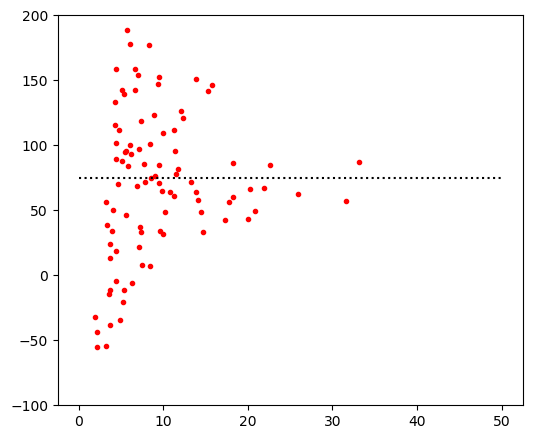

In [227]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Vcmb =  get_ZP_Vmod(Vmod_zp)

Dzp = Vmod_zp['dist']
Vh = Vmod_zp['Vhel']
Vls = Vmod_zp['Vls']

ax.plot(Dzp, Vcmb/Dzp, 'r.')

x = np.linspace(0,50,100)
ax.plot(x,x*0+75, 'k:')

ax.set_ylim(-100,200)

In [228]:
import astropy.stats as st


def getVmod(Vmod_Clusters, key):
    
#     key = 'NEST_100002'


    Vls = Vmod_Clusters[key]['Vls']
    Vhel = Vmod_Clusters[key]['Vhel']
    pgc = Vmod_Clusters[key]['pgc']

    N = len(pgc)
    ra  = np.zeros(N)
    dec = np.zeros(N)
    gl  = np.zeros(N)
    gb  = np.zeros(N)
    sgl = np.zeros(N)
    sgb = np.zeros(N)
    V3k = np.zeros(N)

    for i, idd in enumerate(pgc):

        if idd in ID:
            indx, = np.where(ID==idd)
            j = indx[0]

            ra[i]  = RA[j]
            dec[i] = DEC[j]
            gl[i]  = GL[j]
            gb[i]  = GB[j]
            sgl[i] = SGL[j]
            sgb[i] = SGB[j]
            V3k[i] = Vh2V3k(GL[j],GB[j], Vhel[i])


    Vls_m = st.biweight_location(Vls)
    Vls_m_e = np.sqrt(st.biweight_midvariance(Vls))/np.sqrt(len(Vls))

    V3k_m = st.biweight_location(V3k)
    V3k_m_e = np.sqrt(st.biweight_midvariance(V3k))/np.sqrt(len(V3k))


    omegam=0.27
    omegal=1.-omegam
    c=299800.
    z=V3k_m/c
    ze = V3k_m_e/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod
    Vmod_e=c*ze*fmod

#     print Vls_m, Vls_m_e, V3k_m, V3k_m_e, Vmod, Vmod_e
    return Vmod, Vmod_e


In [229]:
for key in Vmod_Clusters:
    Vmod, Vmod_e = getVmod(Vmod_Clusters, key)
    print key, Vmod_Clusters[key]['name'], '%.0f'%Vmod, '%.0f'%Vmod_e

NEST_200092 Pegasus 3350 77
NEST_200037 NGC70 6760 123
NEST_200017 Abell 539 8953 115
NEST_200005 NGC410 4640 82
NEST_200006 NGC507 4802 125
NEST_100014 Antlia 3156 64
NEST_200003 Abell 262 4717 70
NEST_100001 Coma 7290 129
NEST_100003 Centaurus 3473 150
NEST_100002 Virgo 1530 82
NEST_100005 Abell 1367 7073 71
NEST_200045 NGC80 5520 34
NEST_100007 Abell 2151 (Hercules) 11228 223
NEST_100006 Hydra 4078 71
NEST_100008 Ursa Major 1110 23
NEST_200016 Abell 2634/66 8454 131
NEST_100030 Cancer 4985 111
NEST_200015 Fornax 1290 71
NEST_100018 NGC4065 7500 104
NEST_200012 Abell 400 7623 104


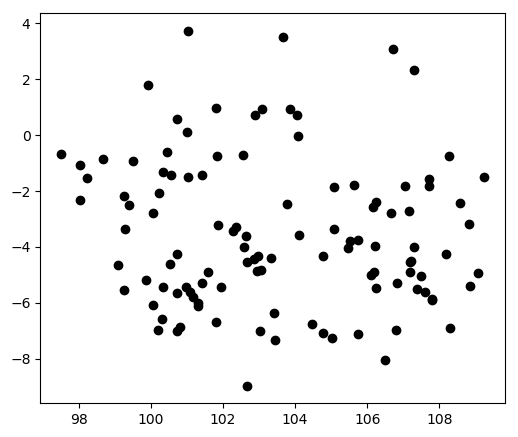

In [230]:
key = 'NEST_100002'


Vls = Vmod_Clusters[key]['Vls']
Vhel = Vmod_Clusters[key]['Vhel']
pgc = Vmod_Clusters[key]['pgc']

N = len(pgc)
ra  = np.zeros(N)
dec = np.zeros(N)
gl  = np.zeros(N)
gb  = np.zeros(N)
sgl = np.zeros(N)
sgb = np.zeros(N)
V3k = np.zeros(N)

for i, idd in enumerate(pgc):

    if idd in ID:
        indx, = np.where(ID==idd)
        j = indx[0]

        ra[i]  = RA[j]
        dec[i] = DEC[j]
        gl[i]  = GL[j]
        gb[i]  = GB[j]
        sgl[i] = SGL[j]
        sgb[i] = SGB[j]
        V3k[i] = Vh2V3k(GL[j],GB[j], Vhel[i])
        
        
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(sgl,sgb, 'ko')